In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import qchem

import numpy as np
import qiskit
from qiskit import QuantumCircuit

In [2]:
from qiskit.quantum_info import Statevector

def getStatevector(circuit):
    """
        从qiskit的QuantumCircuit实例中获取最终的状态向量
    """
    return Statevector(circuit).data

In [3]:
from functools import reduce

# eg. Dag(|a>) = <a|
Dag = lambda matrix: matrix.conj().T
# eg. Kron(I, X, Y) = I ⊗ X ⊗ Y，计算张量用
Kron = lambda *matrices: reduce(np.kron, matrices)

## 1. Building the electronic Hamiltonian

In [4]:
# https://pennylane.ai/qml/demos/tutorial_vqe.html

In [5]:
symbols = ["Be", "H", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.25, 0.0, 0.0, -1.25])

### 1.1 using qml

In [6]:
# 基于JW变换构建的H2哈密顿量
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  14
The Hamiltonian is    (-6.425095473882468) [I0]
+ (-0.8626083329941134) [Z13]
+ (-0.862608332994113) [Z12]
+ (-0.3429011923631434) [Z10]
+ (-0.3429011923631433) [Z11]
+ (-0.07766728565929049) [Z7]
+ (-0.07766728565929044) [Z6]
+ (-0.0776672856592881) [Z8]
+ (-0.0776672856592881) [Z9]
+ (0.07520583536607886) [Z2]
+ (0.07520583536607903) [Z3]
+ (0.09151723863542648) [Z5]
+ (0.0915172386354267) [Z4]
+ (2.445147180385909) [Z0]
+ (2.4451471803859093) [Z1]
+ (0.07731188139099299) [Z10 Z12]
+ (0.07731188139099299) [Z11 Z13]
+ (0.08522546475880556) [Z2 Z4]
+ (0.08522546475880556) [Z3 Z5]
+ (0.09005449130454948) [Z4 Z6]
+ (0.09005449130454948) [Z5 Z7]
+ (0.09005449130459109) [Z4 Z8]
+ (0.09005449130459109) [Z5 Z9]
+ (0.09008668195683335) [Z6 Z10]
+ (0.09008668195683335) [Z7 Z11]
+ (0.09008668195687496) [Z8 Z10]
+ (0.09008668195687496) [Z9 Z11]
+ (0.09218071525384482) [Z6 Z12]
+ (0.09218071525384482) [Z7 Z13]
+ (0.09218071525388732) [Z8 Z12]
+ (0.09218071525388732) [Z9 Z13

In [7]:
generators = qml.symmetry_generators(H)
paulixops = qml.paulix_ops(generators, qubits)

for idx, generator in enumerate(generators):
    print(f"generator {idx+1}: {generator}, paulix_op: {paulixops[idx]}")

generator 1:   (1.0) [Z6 Z7], paulix_op: PauliX(wires=[7])
generator 2:   (1.0) [Z8 Z9], paulix_op: PauliX(wires=[9])
generator 3:   (1.0) [Z0 Z1 Z4 Z5 Z10 Z11], paulix_op: PauliX(wires=[11])
generator 4:   (1.0) [Z0 Z2 Z4 Z6 Z8 Z10 Z12], paulix_op: PauliX(wires=[12])
generator 5:   (1.0) [Z0 Z3 Z4 Z6 Z8 Z10 Z13], paulix_op: PauliX(wires=[13])


C:\Users\Lee\anaconda3\envs\qchem\lib\site-packages\pennylane\operation.py:1886: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(
C:\Users\Lee\anaconda3\envs\qchem\lib\site-packages\pennylane\operation.py:2073: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(


In [8]:
n_electrons = 4 + 2
paulix_sector = qml.qchem.optimal_sector(H, generators, n_electrons)
print(paulix_sector)

[1, 1, 1, -1, -1]


In [9]:
H_tapered = qml.taper(H, generators, paulixops, paulix_sector)
print(H_tapered)

  ((-6.2001659287629725+0j)) [I0]
+ ((-0.34290119236314337+0j)) [Z10]
+ ((-0.15533457131858078+0j)) [Z6]
+ ((-0.15533457131857623+0j)) [Z8]
+ ((-0.023597497601334335+0j)) [X5]
+ ((0.0024660756109456546+0j)) [X6]
+ ((0.0024660756109468056+0j)) [X8]
+ ((0.07520583536607879+0j)) [Z2]
+ ((0.07520583536607896+0j)) [Z3]
+ ((0.09151723863542646+0j)) [Z5]
+ ((0.09151723863542661+0j)) [Z4]
+ ((2.445147180385907+0j)) [Z0]
+ ((2.4451471803859075+0j)) [Z1]
+ ((-0.042064191212470924+0j)) [Y2 Y3]
+ ((-0.021140304255791872+0j)) [Y4 Y10]
+ ((-0.021140304255791872+0j)) [X4 X10]
+ ((-0.017203284765689275+0j)) [X5 X10]
+ ((-0.016083864663655148+0j)) [Y3 Y4]
+ ((-0.012548711856965326+0j)) [Y4 Y5]
+ ((-0.007251818786920404+0j)) [X5 Z10]
+ ((-0.0016033044720107153+0j)) [Y1 Y4]
+ ((-0.0010399625988687126+0j)) [Y0 Y1]
+ ((-0.0008209629633661394+0j)) [Y1 Y3]
+ ((0.0027767001415415203-0j)) [Y1 Y2]
+ ((0.00851049468956058+0j)) [X6 X10]
+ ((0.00851049468956058+0j)) [Y6 Y10]
+ ((0.00851049468956452+0j)) [X8 X10]
+

In [10]:
# Hamiltonian.terms() 获取该哈密顿量中的每个组成成分
# 
# 例如第5项：PauliY(wires=[0]) @ PauliX(wires=[1]) @ PauliX(wires=[2]) @ PauliY(wires=[3])
# 对应系数是 0.04475008
# 对应一个哈密顿量的分量（组成成分）为：0.04475008 * Y ⊗ X ⊗ X ⊗ Y，以此类推
# 
# Question 1: 这个分量是基于JW编码的，具体怎么计算得到的这样的每一项的？（待实现）
# 
Hami = H_tapered.sparse_matrix().toarray()

In [11]:
Hami.shape

(512, 512)

## 2. Initial state

In [12]:
def reset_endianness_circuit(qubits):
    """
        重置qiskit端序
        
        简单说因为pennylane得到的分解中例如 PauliZ(wires=[0]) @ PauliZ(wires=[1]
        其中wires=[0]并不对应qiskit里的qubit[0]（而是qubit[3]，因为端序的问题）
        所以用这个线路把qiskit的端序重置下
        
        eg.下图的resetCircuit线路，处理前，从下到上才对应wires=[0]，wires=[1]，...
        用SWAP把比特交换下就变成正常的顺序（从上到下对应wires=[0]，wires=[1]，...）
        
    """
    circuit = QuantumCircuit(qubits)
    for i in range(qubits // 2):
        circuit.swap(i, qubits - i - 1)
    circuit.barrier()
    
    return circuit

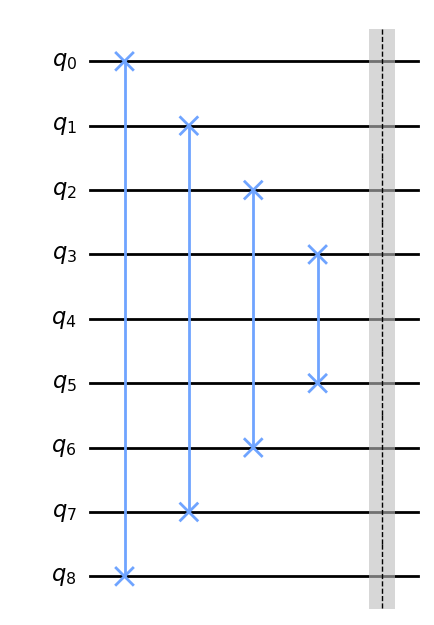

In [13]:
resetCircuit = reset_endianness_circuit(9)
resetCircuit.draw(output='mpl')

In [14]:
def get_initial_circuit(electrons, qubits):
    """
        对应 hf = qml.qchem.hf_state(electrons, qubits)
        即获取初始的电子轨道占据情况（hf_state）
        
        eg. electrons=2(电子数)，qubtis=4(比特数，即总轨道数) => [1, 1, 0, 0]（两个电子占据低位轨道）
    """
    circuit = QuantumCircuit(qubits)
    [ circuit.x(i) for i in range(electrons) ]
    circuit.barrier()
    
    return circuit

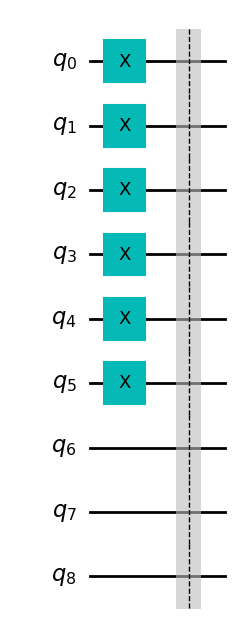

In [15]:
# test - get initial state circuit

electrons = 6 # 电子数
# qubits 计算方法：
# 
# 1. H2 
# H原子外层电子层数一层，最多可容纳2电子 => 可能的原子轨道数2
# 故氢分子是 2*2=4
#
# 2. H2O
# 类推，O原子外层电子数两层，最多可容纳10个电子（2,8） => 原子轨道总数10
# H2O: 2 * 2 + 10 = 14 (qubit) 
qubits = 9

initCircuit = get_initial_circuit(electrons, qubits)
initCircuit.draw(output='mpl')

## 3. Ansatz

In [16]:
# 文章 https://arxiv.org/pdf/1812.09976.pdf 提到，VQE拟设大致有两种类型
#  physically-motivated ansatze (PMA) 与 hardware heuristic ansatze (HHA), 
# 
# 1. PMA 类似于受分子物理理论的影响，设计的某种拟设，比如Givens Rotation，拟设有明确的物理意义：对应单激发或双激发，
# 那么调参可能对应与调某种激发发生的概率(待确认)

# 2. HHA 则类似于搭建神经网络，就是借助计算力暴力求解，搭建的拟设没啥具体的物理意义，就像神经网络一样，所以精度可能不如上面的PMA

# 以下考虑了PMA和HHA的两种拟设构建方式，PMA基于Givens Rotation（理论上还有其他的方法，待研究），HHA用了自设的某个量子神经网络结构

### 3.1 Givens rotation

In [17]:
# 参考 https://pennylane.ai/qml/demos/tutorial_givens_rotations.html

<img src="images/givens.png" width=800 align='left'>

In [18]:
singles, doubles = qml.qchem.excitations(electrons, qubits)
print('single excitations: ', singles) # 对应所有可能的单激发
print('-' * 10)
print('double excitations: ', doubles) # 对应所有可能的双激发

# eg. H2分子，初始轨道占据情况(hf_state) 为[1, 1, 0, 0]
# 存在单激发，[0, 2] 对应电子占据状态从 [1, 1, 0, 0] => [0， 1， 1， 0] 即位置0的电子跃迁到位置2
# 存在双激发，[0, 1, 2, 3] 对应电子占据状态从 [1, 1, 0, 0] => [0， 0， 1， 1]，即位置0与1的电子一同跃迁至轨道2,3 

# 吉文斯旋转（Givens Rotation）通过一组量子门来表示刻画所有可能的激发情况，从而构成拟设（此处细节有待研究）

single excitations:  [[0, 6], [0, 8], [1, 7], [2, 6], [2, 8], [3, 7], [4, 6], [4, 8], [5, 7]]
----------
double excitations:  [[0, 1, 6, 7], [0, 1, 7, 8], [0, 2, 6, 8], [0, 3, 6, 7], [0, 3, 7, 8], [0, 4, 6, 8], [0, 5, 6, 7], [0, 5, 7, 8], [1, 2, 6, 7], [1, 2, 7, 8], [1, 4, 6, 7], [1, 4, 7, 8], [2, 3, 6, 7], [2, 3, 7, 8], [2, 4, 6, 8], [2, 5, 6, 7], [2, 5, 7, 8], [3, 4, 6, 7], [3, 4, 7, 8], [4, 5, 6, 7], [4, 5, 7, 8]]


<img src="images/double.png" width=400 align='left' />

### - single excitation

In [19]:
# 使用PennyLane的静态函数获取Givens Rotation的具体门实现
qml.SingleExcitation.compute_decomposition(8, wires=(0, 2))

[CNOT(wires=[0, 2]), CRY(8, wires=[2, 0]), CNOT(wires=[0, 2])]

In [20]:
def get_single_excitation_circuit(param, qubits):
    """
        参考上述分解结果，构建通用的单激发Givens Rotation线路
    """
    circuit = QuantumCircuit(9)
    
    circuit.cx(*qubits)
    circuit.cry(param, *list(reversed(qubits)))
    circuit.cx(*qubits)
    circuit.barrier()
    
    return circuit

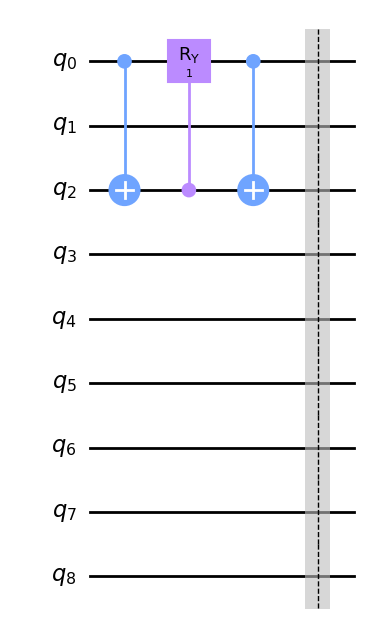

In [21]:
# test - single excitation givens rotation

singleExcitationCircuit = get_single_excitation_circuit(1, [0, 2])
singleExcitationCircuit.draw(output='mpl')

### - double excitation

In [22]:
# 同样使用PennyLane的静态函数获取Givens Rotation的具体门实现
qml.DoubleExcitation.compute_decomposition(8, wires=(0, 1, 2, 3))

[CNOT(wires=[2, 3]),
 CNOT(wires=[0, 2]),
 Hadamard(wires=[3]),
 Hadamard(wires=[0]),
 CNOT(wires=[2, 3]),
 CNOT(wires=[0, 1]),
 RY(1.0, wires=[1]),
 RY(-1.0, wires=[0]),
 CNOT(wires=[0, 3]),
 Hadamard(wires=[3]),
 CNOT(wires=[3, 1]),
 RY(1.0, wires=[1]),
 RY(-1.0, wires=[0]),
 CNOT(wires=[2, 1]),
 CNOT(wires=[2, 0]),
 RY(-1.0, wires=[1]),
 RY(1.0, wires=[0]),
 CNOT(wires=[3, 1]),
 Hadamard(wires=[3]),
 CNOT(wires=[0, 3]),
 RY(-1.0, wires=[1]),
 RY(1.0, wires=[0]),
 CNOT(wires=[0, 1]),
 CNOT(wires=[2, 0]),
 Hadamard(wires=[0]),
 Hadamard(wires=[3]),
 CNOT(wires=[0, 2]),
 CNOT(wires=[2, 3])]

In [25]:
def get_double_excitation_circuit(param, qubits):
    """
        参考上述分解结果，构建通用的双激发Givens Rotation线路
        
        Question 2: Givens Rotation的线路具体是怎么设计的（依据，为什么是这样）？
        
        -> https://arxiv.org/pdf/2106.13839.pdf
    """
    circuit = QuantumCircuit(9)
    
    circuit.cx(qubits[2], qubits[3])
    circuit.cx(qubits[0], qubits[2])
    circuit.h(qubits[3])
    circuit.h(qubits[0])
    circuit.cx(qubits[2], qubits[3])
    circuit.cx(qubits[0], qubits[1])
    circuit.ry(param/8, qubits[1])
    circuit.ry(-param/8, qubits[0])
    circuit.cx(qubits[0], qubits[3])
    circuit.h(qubits[3])
    circuit.cx(qubits[3], qubits[1])
    circuit.ry(param/8, qubits[1])
    circuit.ry(-param/8, qubits[0])
    circuit.cx(qubits[2], qubits[1])
    circuit.cx(qubits[2], qubits[0])
    circuit.ry(-param/8, qubits[1])
    circuit.ry(param/8, qubits[0])
    circuit.cx(qubits[3], qubits[1])
    circuit.h(qubits[3])
    circuit.cx(qubits[0], qubits[3])
    circuit.ry(-param/8, qubits[1])
    circuit.ry(param/8, qubits[0])
    circuit.cx(qubits[0], qubits[1])
    circuit.cx(qubits[2], qubits[0])
    circuit.h(qubits[0])
    circuit.h(qubits[3])
    circuit.cx(qubits[0], qubits[2])
    circuit.cx(qubits[2], qubits[3])
    circuit.barrier()
    
    return circuit

<img src="images/G.png" width=940 align='left'>

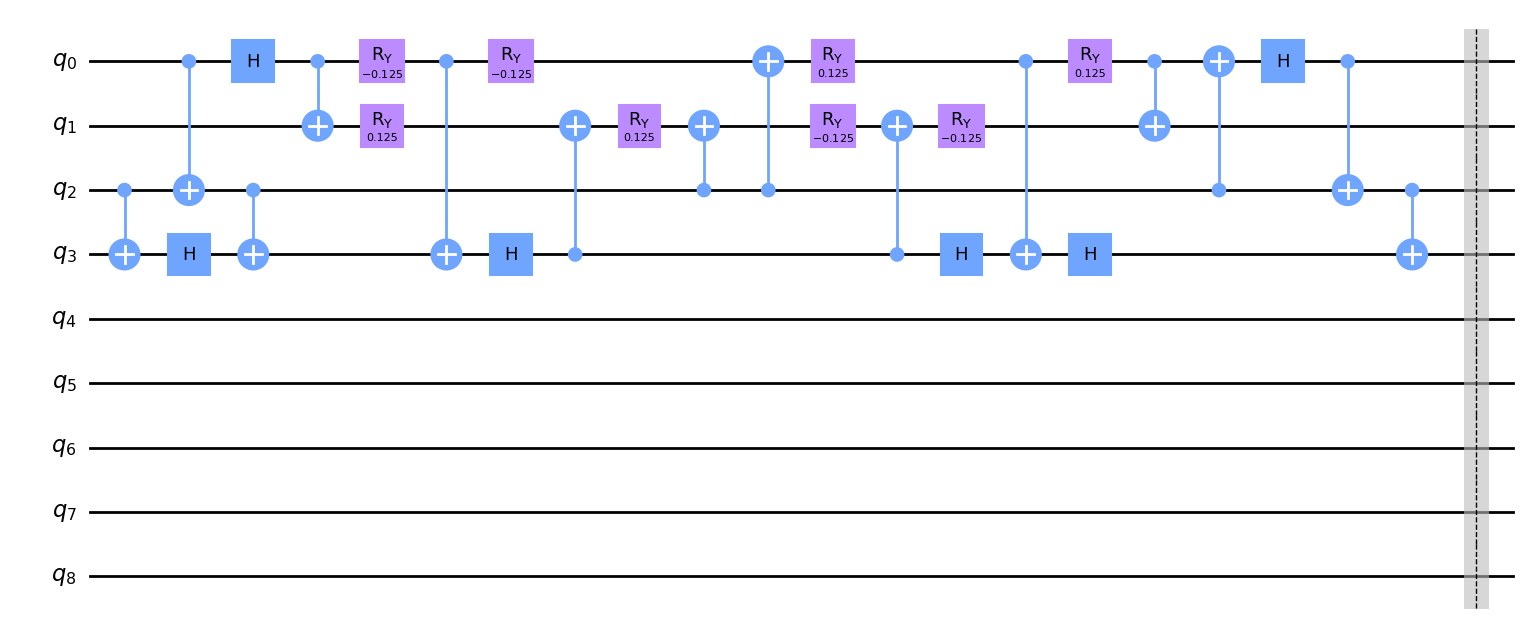

In [26]:
# test - double excitation givens rotation

doubleExcitationCircuit = get_double_excitation_circuit(1, [0, 1, 2, 3])
doubleExcitationCircuit.draw(output='mpl')

### - full Givens rotation circuit

In [27]:
def get_givens_circuit(params):
    """
        组装完整的基于Givens Rotation的拟设线路，包含所有的单激发与双激发
        
        注：https://pennylane.ai/qml/demos/tutorial_vqe.html 的例子求解H2分子时候，
        基于某种化学假设，只考虑了双激发（不清楚具体理由），这边实现的是同时考虑所有单激发与双激发
        结果也可以正常求得（感觉更完整合理些）
        
        单激发与双激发的类型这里暂时写死，有待未来完善
    """
    circuit = QuantumCircuit(9)
    
    idx = 0
    
    for single in singles:
        circuit = circuit.compose(get_single_excitation_circuit(params[idx], single))
        idx += 1
        
    for double in doubles:
        circuit = circuit.compose(get_double_excitation_circuit(params[idx], double))
        idx += 1
        
    return circuit

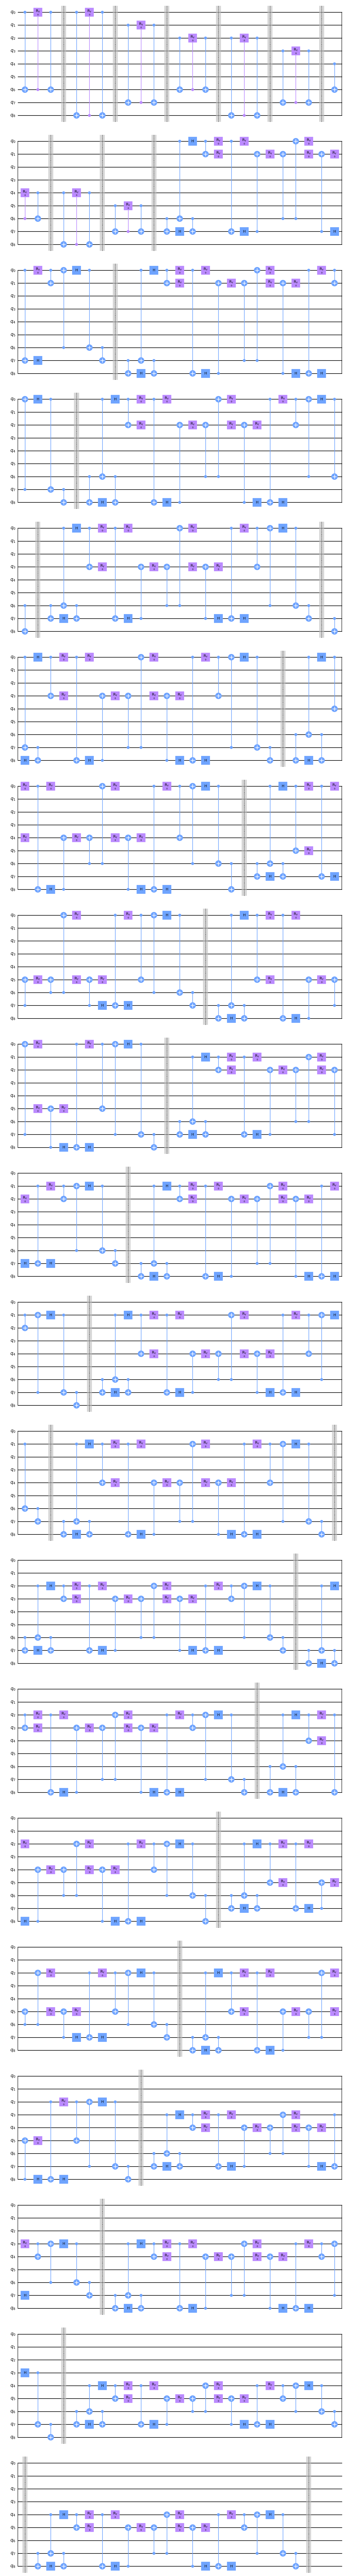

In [28]:
givensCircuit = get_givens_circuit([0] * (len(singles) + len(doubles)))
givensCircuit.draw(output='mpl')

### 3.2 VQC(QNN) based

In [29]:
# https://www.researchgate.net/publication/363858547_Shuffle-QUDIO_accelerate_distributed_VQE_with_trainability_enhancement_and_measurement_reduction

<img src="images/HEA.png" width=500 align='left'>

In [30]:
# hardware heuristic ansatze

<img src="images/QNN.png" width=600 align='left'>

In [31]:
def get_QNN_circuit(params, n_qubits=9):
    """
        某种量子神经网络（QNN）线路结构，充当拟设部分
        
        因为没有考虑物理意义，纯粹是用神经网络的计算、拟合能力强行算，属于HHA法
        QNN结构可以有很多中不同的可能，大体上是旋转门组成的旋转层 + 双比特门组成的纠缠层
        这里给的只是一个可能
    """
    circuit = QuantumCircuit(n_qubits)
    
    layer = len(params) // (n_qubits * 2)
    
    for i in range(n_qubits):
        circuit.rx(params[i * 2], i)
        circuit.rz(params[i * 2 + 1], i)
    
    for i in range(layer - 1):
        j = (i + 1) * (2 * n_qubits)
        
        
        for k in range(n_qubits - 1):
            circuit.cx(k, k + 1)
        
        circuit.barrier()
        
        for k in range(n_qubits):
            circuit.rx(params[j + k * 2], k)
            circuit.rz(params[j + k * 2 + 1], k)
        
        circuit.barrier()
    
    return circuit

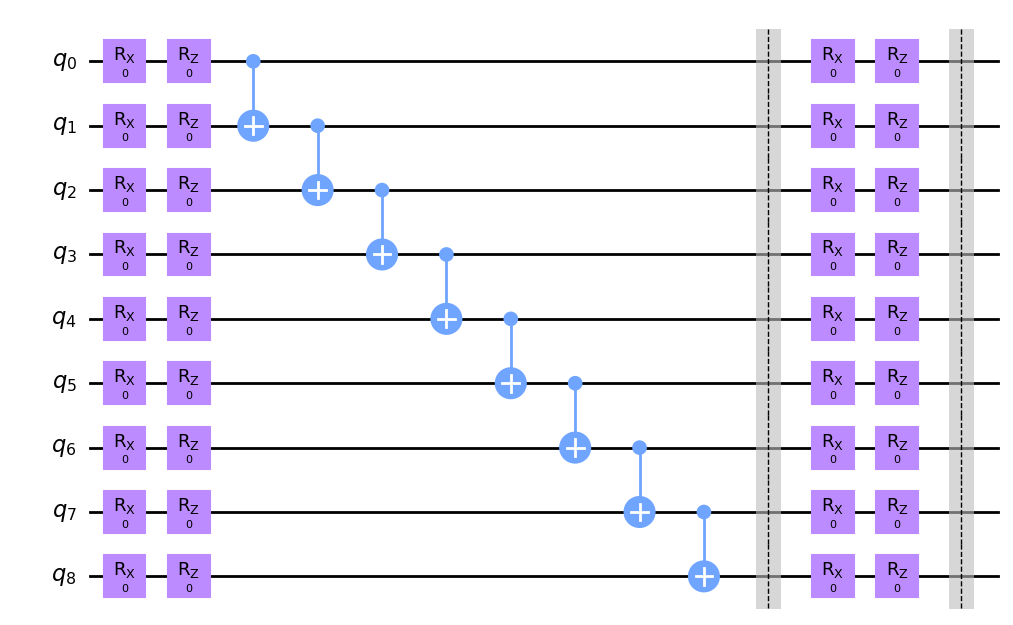

In [32]:
# test - get_QNN_circuit

get_QNN_circuit([0] * 36, 9).draw(output='mpl')

## 4. VQE

### - Tool Functions

In [33]:
def get_full_circuit(ansatz, params):
    """
        搭建完整线路
        
        :param ansatz: 构建拟设线路的函数
        :param params: 拟设函数的参数，即ansatz(params)返回拟设线路
        
        1. resetCircuit 在整个线路前后用来调整端序（可以无视）
        2. initCircuit 对应初始 hf_state，eg. [1, 1, 0, 0]
        3. ansatz(params) 对应拟设（带参数）主体
    """
    return resetCircuit.compose(
        initCircuit.compose(
            ansatz(params).compose(resetCircuit)
        )
    )

In [34]:
def expval(Hami, circuit):
    """
        基于哈密顿量与拟设计算期望值
        
        1. 初始态是hf_state，eg. [1, 1, 0, 0] 记为 |φ>,
        2. 通过拟设（例如一组Givens Rotation），态演化为 U(θ)|φ>, U(θ)对应某个拟设，记U(θ)|φ> = |Ψ(θ)>
        3. 计算和哈密顿量间的期望：<Ψ(θ)| H |Ψ(θ)>
    """
    state = getStatevector(circuit) # 获取线路终态
    size = len(state)
    
    right = state.reshape(size, 1)
    left = Dag(right)
    
    # 计算 <Ψ(θ)| H |Ψ(θ)>
    return (left @ Hami @ right)[0, 0].real

In [35]:
# # test - expval

# circuit = get_full_circuit(get_givens_circuit, [0.1, 0.2, 0.3])

# print('expval result: ', expval(Hami, circuit))

In [45]:
def plot(energies, color):
    """
        绘制训练结果和经典计算结果的比较
    """
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)

    # 该经典结果数值是使用pyscf计算的，基于Full CI法
    # Question 3：有必要装下pyscf，用pyscf跑下结果是否如下：
    E_fci = -7.66

    n = len(energies)
    plt.plot(range(n), energies, "o", ls="dashed", color=color)
#     plt.plot(range(n), np.full(n, E_fci), color="#FF6666")
    plt.xlabel("Optimization step", fontsize=13)
    plt.ylabel("Energy (FCI)", fontsize=13)

### - Train VQE

In [37]:
def calculate_grad(Hami, ansatz, params):
    """
        基于参数偏移计算变分量子线路的梯度
        
        :param ansatz: 同get_full_circuit中，即ansatz(params)返回拟设线路
        
        参数偏移法：grad = [ f(θ + π/2) - f(θ - π/2) ] / 2
    """
    grads = []
    
    for i in range(len(params)):
        params[i] += np.pi / 2
        a = expval(Hami, get_full_circuit(ansatz, params))
        params[i] -= np.pi
        b = expval(Hami, get_full_circuit(ansatz, params))
        params[i] += np.pi / 2
        
        grad = (a - b) / 2
        grads.append(grad)
        
    return np.array(grads)

In [38]:
def train_VQE(Hami, ansatz, params, *, epoch=100, lr=0.01, tol=1e-6):
    """
        :param Hami: 分子哈密顿量
        :param ansatz: 构建拟设的函数
        :param params: 拟设的初始参数，则拟设线路为：ansatz(params)，完整线路为get_full_circuit(ansatz, params)
    """
    energy = None
    energies = []
    prev_energy = 9999
    
    # optimizer hyperparameters
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    m = v = np.array([0.0 for i in range(len(params))])

    for step in range(epoch):
        # 1. loss(energy) calculation
        circuit = get_full_circuit(ansatz, params)
        energy = expval(Hami, circuit)
        energies.append(energy)
        print(f'Epoch {step + 1}/{epoch}: Energy: {energy}')
        
        # 2. grad calculation
        grad = calculate_grad(Hami, ansatz, params)
        
        # 3. update parameters
        # Adam optimizer 实现参数更新
        m = beta_1 * m + (1 - beta_1) * grad
        v = beta_2 * v + (1 - beta_2) * (grad ** 2)
        m_ = m / (1 - beta_1 ** (step + 1))
        v_ = v / (1 - beta_2 ** (step + 1))
        params -= lr * m_ / (v_ ** 0.5 + epsilon)
        
        if  abs(prev_energy - energy) <= tol:
            break
        prev_energy = energy
    
    print('------- Fin -------')
    print('Final Energy: ', energy)
    print('Parameters: ', params)
    
    return energies, params

### 4.1 physically-motivated ansatze (PMA)

### - 4.1.1 Givens Rotations 

In [39]:
init_params_Givens = np.random.randn(len(singles) + len(doubles))
energies_Givens, params_Givens = train_VQE(Hami, get_givens_circuit, init_params_Givens, epoch=300, lr=0.05)

Epoch 1/300: Energy: -5.425266238865956
Epoch 2/300: Energy: -5.861098801219954
Epoch 3/300: Energy: -6.286154089413113
Epoch 4/300: Energy: -6.703563188008221
Epoch 5/300: Energy: -7.110277467409821
Epoch 6/300: Energy: -7.503490064650109
Epoch 7/300: Energy: -7.880558721666498
Epoch 8/300: Energy: -8.240040201789512
Epoch 9/300: Energy: -8.582999252462832
Epoch 10/300: Energy: -8.910670598435075
Epoch 11/300: Energy: -9.22236906146807
Epoch 12/300: Energy: -9.51635678251673
Epoch 13/300: Energy: -9.791315599805504
Epoch 14/300: Energy: -10.047711080944154
Epoch 15/300: Energy: -10.28885039441759
Epoch 16/300: Energy: -10.520341473888443
Epoch 17/300: Energy: -10.747637025420497
Epoch 18/300: Energy: -10.974134585654049
Epoch 19/300: Energy: -11.200864614806719
Epoch 20/300: Energy: -11.42695917858142
Epoch 21/300: Energy: -11.650340868962807
Epoch 22/300: Energy: -11.868399549186949
Epoch 23/300: Energy: -12.078484710914076
Epoch 24/300: Energy: -12.27814783441269
Epoch 25/300: Energ

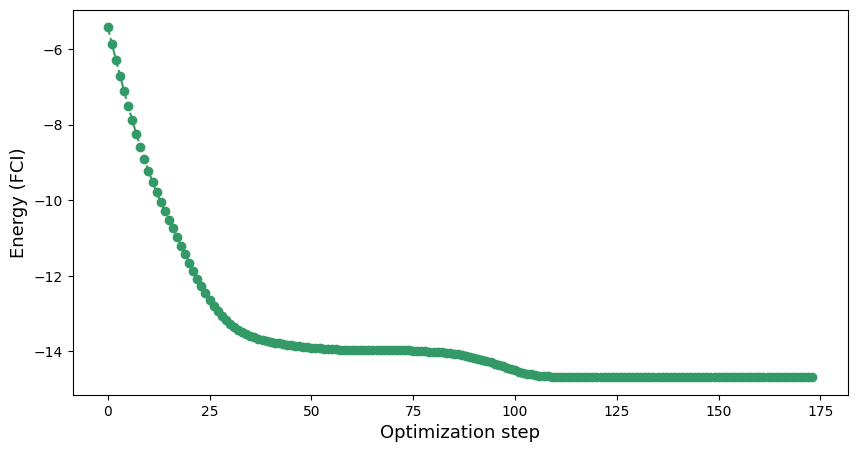

In [46]:
plot(energies_Givens, '#339966')

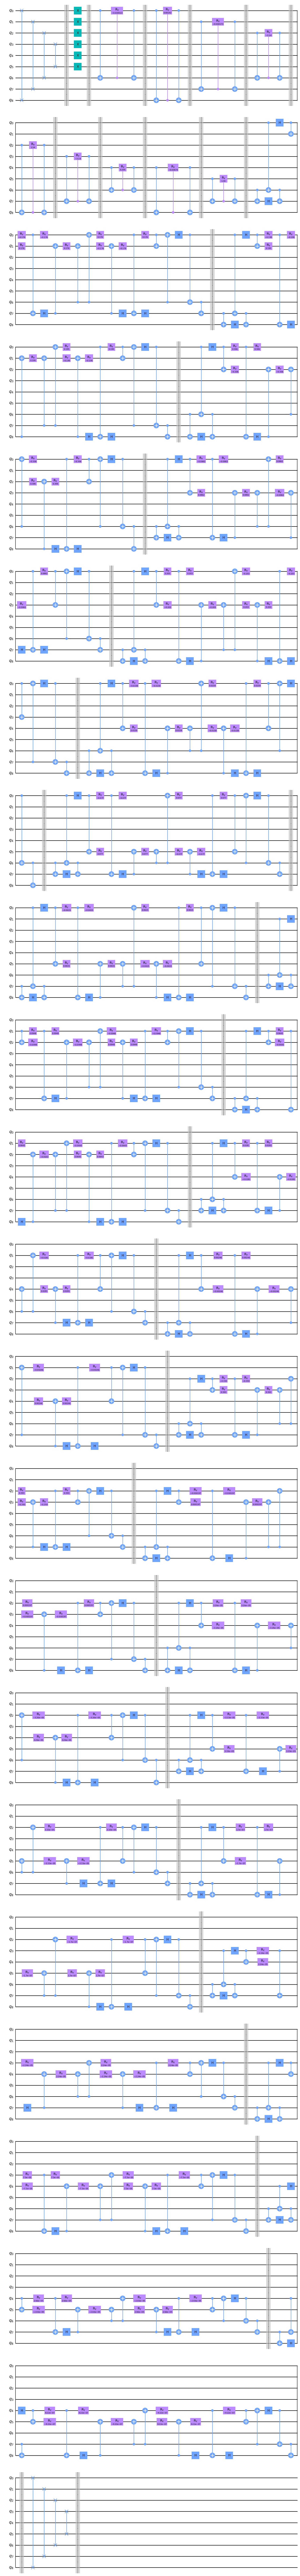

In [41]:
# 完整VQE（基于Givens Rotation）线路
get_full_circuit(get_givens_circuit, params_Givens).draw(output='mpl')

### 4.2 hardware heuristic ansatze (HHA)

### - 4.2.1 QNN

In [42]:
init_params_QNN = np.random.randn(18 * 8)
energies_QNN, params_QNN = train_VQE(Hami, get_QNN_circuit, init_params_QNN, epoch=300, lr=0.1)

Epoch 1/300: Energy: -6.037801632442226
Epoch 2/300: Energy: -7.089206342906353
Epoch 3/300: Energy: -7.757156302555199
Epoch 4/300: Energy: -8.20600538878502
Epoch 5/300: Energy: -8.603346223617782
Epoch 6/300: Energy: -9.01832953315259
Epoch 7/300: Energy: -9.449993659781281
Epoch 8/300: Energy: -9.863733965829104
Epoch 9/300: Energy: -10.26795493820999
Epoch 10/300: Energy: -10.61752589231613
Epoch 11/300: Energy: -10.92253977028065
Epoch 12/300: Energy: -11.173734171943499
Epoch 13/300: Energy: -11.343337117634793
Epoch 14/300: Energy: -11.458184743455826
Epoch 15/300: Energy: -11.575277885386143
Epoch 16/300: Energy: -11.717311759800598
Epoch 17/300: Energy: -11.81719999795067
Epoch 18/300: Energy: -11.84636346246428
Epoch 19/300: Energy: -11.853613596207428
Epoch 20/300: Energy: -11.887334686288956
Epoch 21/300: Energy: -11.954803464470313
Epoch 22/300: Energy: -12.050810454180391
Epoch 23/300: Energy: -12.164805482750214
Epoch 24/300: Energy: -12.271167423535871
Epoch 25/300: En

Epoch 196/300: Energy: -14.698635155549482
Epoch 197/300: Energy: -14.698640599721777
Epoch 198/300: Energy: -14.698645611796609
Epoch 199/300: Energy: -14.698650090098484
Epoch 200/300: Energy: -14.69865394760372
Epoch 201/300: Energy: -14.698656811811562
Epoch 202/300: Energy: -14.698658387671806
Epoch 203/300: Energy: -14.698657800132263
------- Fin -------
Final Energy:  -14.698657800132263
Parameters:  [-1.57077048e+00 -2.82956373e-01 -2.86816783e-02 -1.29938115e+00
  1.07128149e+00 -1.27024892e-02 -1.57118557e+00  3.00492255e+00
  1.56674160e+00  9.23140329e-03 -8.11597470e-01  2.56261341e+00
 -1.58142820e+00  1.57891054e+00  1.50719559e+00 -2.12040069e+00
  5.14455669e-01 -3.12955724e+00 -2.69403213e-02  2.81190622e-01
  1.57052275e+00 -1.85591047e+00  1.42462221e-01 -6.39750077e-03
  1.56989573e+00  1.57018885e+00  1.58017091e+00  4.00560822e-01
  2.29498091e+00 -9.80647550e-04 -1.48334649e+00  1.68503199e+00
 -1.57772181e+00 -1.30416826e+00 -3.56334823e-02  1.59129185e+00
  1.

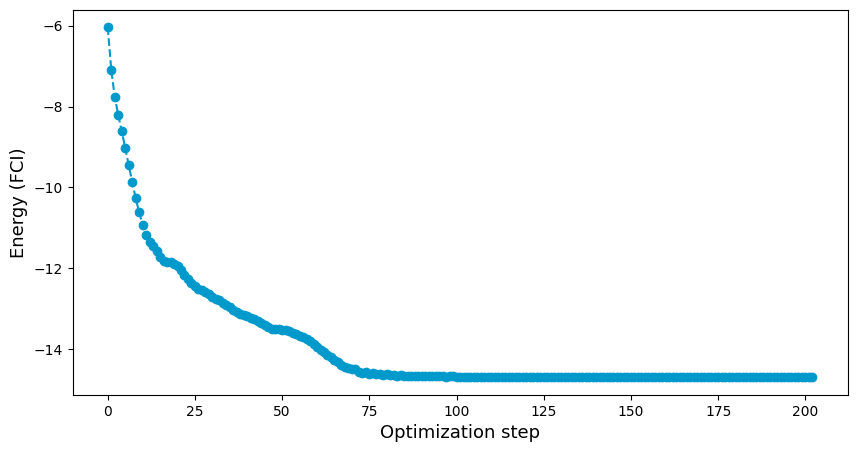

In [47]:
plot(energies_QNN, '#0099CC')

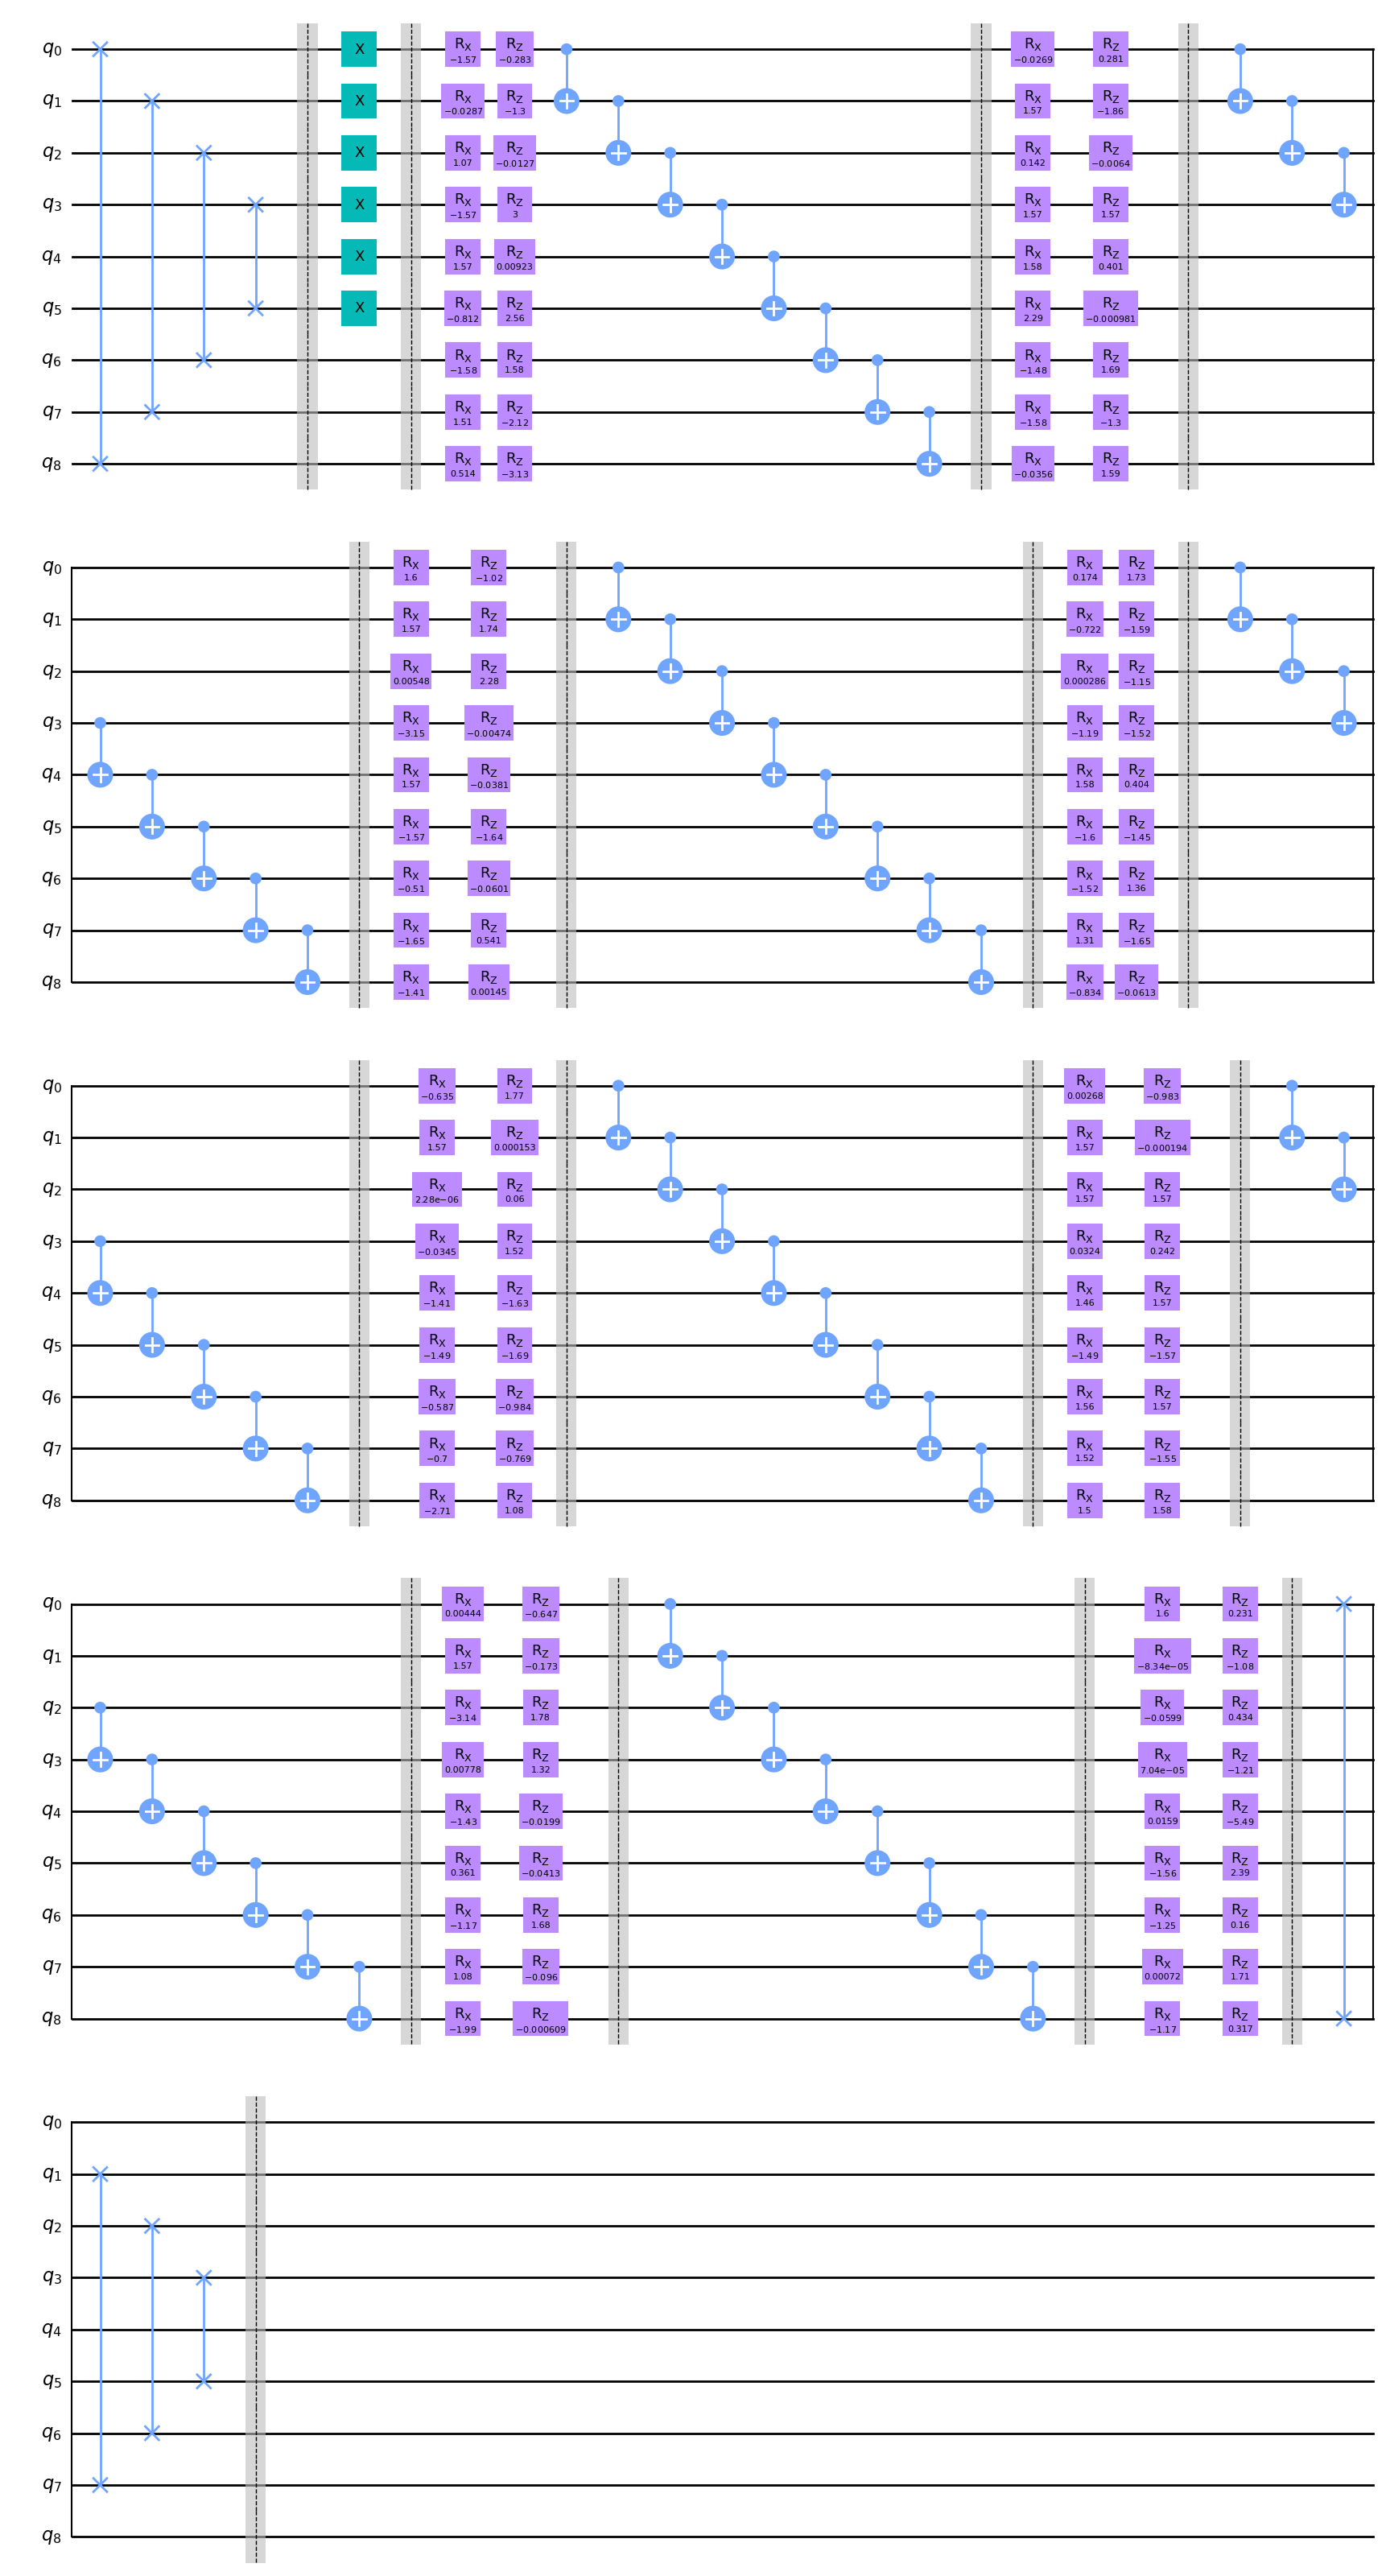

In [44]:
# 完整VQE（基于QNN）线路
get_full_circuit(get_QNN_circuit, params_QNN).draw(output='mpl')